In [ ]:
# Loading modules

import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
from itertools import chain

# Visualization tools

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, export_png
output_notebook()

# Modeling tools

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import scipy

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg

# Ignoring warnings

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading data

df = pd.read_csv("/content/CO2.csv", header=[0, 1, 2], comment='"')
df.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
,,,,,,adjusted,,adjusted fit,filled,adjusted filled
,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   (  Yr,     ,     )                         744 non-null    int64  
 1   ( Mn,    ,    )                            744 non-null    int64  
 2   (    Date,         ,    Excel)             744 non-null    int64  
 3   (      Date,           ,           )       744 non-null    float64
 4   (     CO2,         ,    [ppm])             744 non-null    float64
 5   (seasonally,   adjusted,     [ppm] )       744 non-null    float64
 6   (        fit,            ,       [ppm])    744 non-null    float64
 7   (  seasonally, adjusted fit,     [ppm])    744 non-null    float64
 8   (      CO2,    filled,        [ppm])       744 non-null    float64
 9   ( seasonally, adjusted filled,     [ppm])  744 non-null    float64
dtypes: float64(7), int64(3)
me

In [ ]:
# Fixing column names

df.columns = [
    " ".join(
        [col[0].strip(),
         col[1].strip(),
         col[2].strip()]
    ).strip()
    for col in df.columns.values
]
df.columns

Index(['Yr', 'Mn', 'Date  Excel', 'Date', 'CO2  [ppm]',
       'seasonally adjusted [ppm]', 'fit  [ppm]',
       'seasonally adjusted fit [ppm]', 'CO2 filled [ppm]',
       'seasonally adjusted filled [ppm]'],
      dtype='object')

# **What is PPM ?**

**PPM** stands for **"parts per million"**. It is a unit of measurement used to describe the concentration of a substance in the air or water. In the context of CO2 (carbon dioxide) concentrations, ppm indicates the number of CO2 molecules in a million molecules of air.

For example, if the CO2 concentration is 400 ppm, it means there are 400 molecules of CO2 in every million molecules of air. This unit is commonly used in atmospheric sciences to measure and report the concentration of greenhouse gases, including CO2, in the atmosphere. The measurement helps scientists understand the impact of CO2 on climate change and monitor its changes over time.

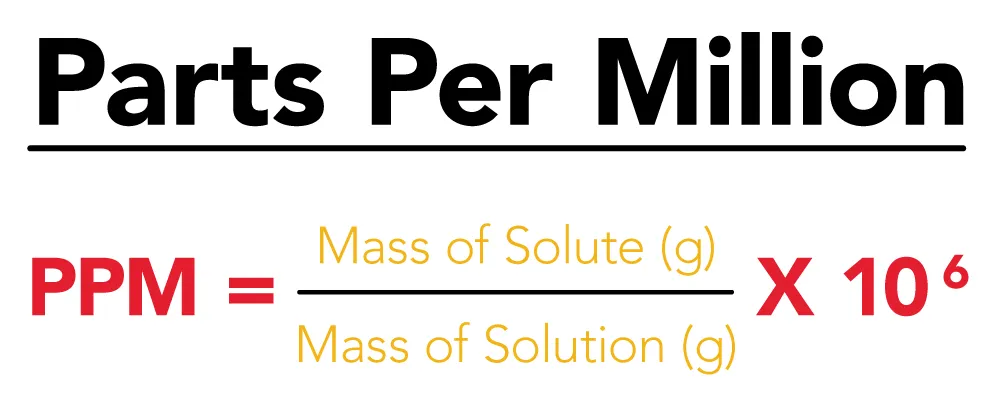

In [ ]:
# Creating a copy of the dataframe and preparing data

co2 = df.copy()

In [ ]:
# Selecting columns

co2 = co2[['Yr','Mn', 'CO2  [ppm]']]
co2.columns = ['Year', 'Month', 'CO2']
co2.head()

,Year,Month,CO2
0,1958,1,-99.99
1,1958,2,-99.99
2,1958,3,315.70
3,1958,4,317.45
4,1958,5,317.51


In [ ]:
# Replacing -99.99 with NaN

co2['CO2'].replace(-99.99, np.nan, inplace=True)
co2.head()

,Year,Month,CO2
0,1958,1,NaN
1,1958,2,NaN
2,1958,3,315.70
3,1958,4,317.45
4,1958,5,317.51


In [ ]:
# Creating a time index measured in the middle of the month starting from zero

co2['time'] = (co2.index.values + 0.5 / 12)
co2.head()

,Year,Month,CO2,time
0,1958,1,NaN,0.041667
1,1958,2,NaN,1.041667
2,1958,3,315.70,2.041667
3,1958,4,317.45,3.041667
4,1958,5,317.51,4.041667


In [ ]:
# Checking for null values

co2[co2.CO2.isnull()]

,Year,Month,CO2,time
0,1958,1,NaN,0.041667
1,1958,2,NaN,1.041667
5,1958,6,NaN,5.041667
9,1958,10,NaN,9.041667
73,1964,2,NaN,73.041667
74,1964,3,NaN,74.041667
75,1964,4,NaN,75.041667
741,2019,10,NaN,741.041667
742,2019,11,NaN,742.041667
743,2019,12,NaN,743.041667


In [ ]:
# Dropping missing values and reseting index

co2 = co2.dropna()
co2.reset_index(drop=True, inplace=True)

In [ ]:
# Creating design matrix X from the time index

X = co2['time']
len(X)

734

In [ ]:
# Creating labels from the co2 values

y = co2['CO2']
len(y)

734

In [ ]:
# Splitting the data with 80:20 split

train_size = int(len(X)*0.8) # training with the first values of the timeframe
test_size = len(X) - train_size # testing predictions with the last values of the timeframe

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

587 587
147 147


In [ ]:
X_train

0        2.041667
1        3.041667
2        4.041667
3        6.041667
4        7.041667
          ...    
582    589.041667
583    590.041667
584    591.041667
585    592.041667
586    593.041667
Name: time, Length: 587, dtype: float64

In [ ]:
# Visualizing training data

p = figure(width = 800, height = 600, title = "Visualization of Training Data")
p.scatter(X_train,y_train,size=5, line_color="navy", fill_color="orange", fill_alpha=0.5)
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
show(p)

There appears to be a clear linearly increasing trend on the data.
That is why we will fit Linear Regression Model to our train data .

In [ ]:
# Fitting data to linear regression model

lr = LinearRegression().fit(np.array(X_train).reshape(-1,1), y_train)

In [ ]:
# Model coefficients

lr_coefficients = [lr.coef_[0], lr.intercept_]
print("The linear model F(t) = " +str(lr_coefficients[0])+"*t + " +str(lr_coefficients[1])+" ")

The linear model F(t) = 0.11722426245179315*t + 309.04538451932365 


In [ ]:
# Plotting linear fit of the model

lr_linear_fit = lr.predict(np.array(X_train).reshape(-1,1))

p = figure(width=800, height=600, title='Modeling with the Linear Model')
p.scatter(X_train, y_train, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(X_train, lr_linear_fit, line_color="orange", line_width=2.5, legend_label ="Linear Fit")
p.legend.location = "bottom_right"
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
show(p)

The linear line seems to fit quite well but not perfectly as we can by having a closer look at the beginning and at the end of the scatter points.

<b> Plot the residual error $R_{linear}(t)=C(t)-F_1(t)$. Report the root mean squared error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for this model.</b>

In [ ]:
# Predicting with test data

lr_predictions = lr.predict(np.array(X_test).reshape(-1,1))

p = figure(width=800, height=600, title = "Predicting with Linear Model")
p.scatter(X_test, y_test, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, lr_predictions, line_color="orange", line_width=2.5, legend_label ="Linear Model Predictions")
p.xaxis.ticker = [620, 660, 700, 740]
p.xaxis.major_label_overrides = {620: '2010', 660: '2013', 700: '2016', 740: '2019'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

We notice that the model doesn't predict very well as the line is way outside the predicted data points.



In [ ]:
# Plotting the residuals

lr_residuals = y_train - lr_linear_fit
p = figure(width=800, height=600, title = "Residuals for Linear Model")
p.scatter(X_train, lr_residuals ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="Residuals")

p.yaxis.axis_label ='Residual'
p.legend.location = "bottom_right"
show(p)

We notice a concave shape on the residuals that indicates that the model is not able to predict very well as the residuals are not scattered randomly around zero. The residuals show that they hide a pattern that hasn't been found yet with the model.

In [ ]:
# Calculating the prediction errors RMSE and MAPE

rmse_linear = (mean_squared_error(y_test, lr_predictions, squared=False))
print("The RMSE on test data is " + str(rmse_linear))

mape_linear = mean_absolute_percentage_error(y_test, lr_predictions)
print("The MAPE on test data is " + str(mape_linear*100)) # as a percentage

The RMSE on test data is 10.641458521874693
The MAPE on test data is 2.450454956443149


In the problems below, we will fit quadratic and cubic models to the data and compute again $\text {RMSE}$ and $\text {MAPE}$. We will then evaluate which of these models is the lowest degree model that still captures the trend of the data best sufficiently.

Now, fit the data to a quadratic model $F_2(t) \sim \beta _0 + \beta _1 t + \beta _2 t^2$.

<b> What are the values of $\hat\beta_0$, $\hat\beta_1$ and $\hat\beta_2$?</b>

In [ ]:
# Fitting quadratic model

qr = make_pipeline(PolynomialFeatures(2),LinearRegression())
qr.fit(np.array(X_train).reshape(-1, 1), y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [ ]:
# Quadratic model coefficients

qr_coefficients = [qr.named_steps.linearregression.coef_[-1], qr.named_steps.linearregression.coef_[-2], qr.named_steps.linearregression.intercept_]
print("The quadratic model F(t) = " +str(qr_coefficients[0])+"*t^2 + " +str(qr_coefficients[1])+"*t + " +str(qr_coefficients[2])+"")

The quadratic model F(t) = 8.414930345918004e-05*t^2 + 0.06691855529151983*t + 314.131237514398


In [ ]:
# Plotting quadratic fit of the model

qr_quadratic_fit = qr.predict(np.array(X_train).reshape(-1, 1))

p = figure(width=800, height=600, title = "Modeling with the Quadratic Model")
p.scatter(X_train, y_train, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(X_train, qr_quadratic_fit, line_color="orange", line_width=2.5, legend_label ="Quadratic Fit")
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

This time the fit is better also in the beginning and at the end which indicates this is a better model compared to the previous one in modeling the data.

<b> Plot the residual error $R_{quadratic}(t)=C(t)-F_2(t)$. Report the root mean squared prediction error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for the quadratic model.</b>

In [ ]:
# Predicting with test data

qr_predictions = qr.predict(np.array(X_test).reshape(-1,1))

p = figure(width=800, height=600, title = "Predicting with Quadratic Model")
p.scatter(X_test, y_test, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, qr_predictions, line_color="orange", line_width=2.5, legend_label ="Quadratic Model Predictions")
p.xaxis.ticker = [620, 660, 700, 740]
p.xaxis.major_label_overrides = {620: '2010', 660: '2013', 700: '2016', 740: '2019'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

We see that the fit of the line is much better than what it was previously.

In [ ]:
# Plotting the residuals

qr_residuals = y_train - qr_quadratic_fit
p = figure(width=800, height=600, title = "Residuals for Quadratic Model")
p.scatter(X_train, qr_residuals ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="Residuals")

p.yaxis.axis_label ='Residual'
p.legend.location = "top_right"
show(p)

This time the residuals are scattered more randomly than previously around zero which indicates there isn't a systematic problem with the model.

In [ ]:
# Calculating the prediction errors RMSE and MAPE

rmse_quadratic = (mean_squared_error(y_test, qr_predictions, squared=False))
print("The RMSE on test data is " + str(rmse_quadratic))

mape_quadratic = mean_absolute_percentage_error(y_test, qr_predictions)
print("The MAPE on test data is " + str(mape_quadratic*100)) # as a percentage

The RMSE on test data is 2.5013322194904357
The MAPE on test data is 0.5320319129742265


Now, fit the data to a cubic model $F_3(t) \sim \gamma _0 + \gamma _1 t + \gamma _2 t^2 + \gamma _3 t^3$.

<b> What are the values of $\hat\gamma_0$, $\hat\gamma_1$, $\hat\gamma_2$ and $\hat\gamma_3$?</b>

In [ ]:
# Fitting cubic model

cr = make_pipeline(PolynomialFeatures(3),LinearRegression())
cr.fit(np.array(X_train).reshape(-1, 1), y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [ ]:
# Cubic model coefficients

cr_coefficients = [cr.named_steps.linearregression.coef_[-1], cr.named_steps.linearregression.coef_[-2], cr.named_steps.linearregression.coef_[-3], cr.named_steps.linearregression.intercept_]
print("The cubic model F(t) = " +str(cr_coefficients[0])+"*t^3 + " +str(cr_coefficients[1])+"*t^2 + "+str(cr_coefficients[2])+"*t + " + str(cr_coefficients[3])+"")

The cubic model F(t) = -6.847418831251728e-08*t^3 + 0.0001454445104704484*t^2 + 0.05220798466867016*t + 314.88242425697143


In [ ]:
# Plotting cubic fit of the model

cr_cubic_fit = qr.predict(np.array(X_train).reshape(-1, 1))

p = figure(width=800, height=600, title = "Modeling with Cubic Model")
p.scatter(X_train, y_train, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(X_train, cr_cubic_fit, line_color="orange", line_width=2.5, legend_label ="Cubic Fit")
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

The fit seems to be quite good but we need to compare the residuals and the errors the model makes while predicting to the previous models in order to see which one performs the best.

<b> Plot the residual error $R_{cubic}(t)=C(t)-F_3(t)$. Report the root mean squared prediction error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for this model.</b>

In [ ]:
# Predicting with test data

cr_predictions = cr.predict(np.array(X_test).reshape(-1,1))

p = figure(width=800, height=600, title = "Predicting with Cubic Model")
p.scatter(X_test, y_test, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, cr_predictions, line_color="orange", line_width=2.5, legend_label ="Cubic Model Predictions")
p.xaxis.ticker = [620, 660, 700, 740]
p.xaxis.major_label_overrides = {620: '2010', 660: '2013', 700: '2016', 740: '2019'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

Although the model fit quite well with the training data once we try to predict we notice that the model does a worse job than the previous quadratic version.

In [ ]:
# Plotting the residuals

cr_residuals = y_train - cr_cubic_fit
p = figure(width=800, height=600, title = "Residuals for Cubic Model")
p.scatter(X_train, cr_residuals ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="Residuals")

p.yaxis.axis_label ='Residual'
p.legend.location = "top_right"
show(p)

The residuals show a random scattering around zero which indicates that there isn't a systematic problem with the model.

In [ ]:
# Calculating the prediction errors RMSE and MAPE

rmse_cubic = (mean_squared_error(y_test, cr_predictions, squared=False))
print("The RMSE on test data is " + str(rmse_cubic))

mape_cubic = mean_absolute_percentage_error(y_test, cr_predictions)
print("The MAPE on test data is " + str(mape_cubic*100)) # as a percentage

The RMSE on test data is 4.14937071438948
The MAPE on test data is 0.8483502728599343


Based on the predictions and analysing the results of the residuals and errors we notice that the best model to represent the data is the quadratic model which has no systematic trend in its residuals and which has the lowest $RMSE$ and $MAPE$ on predicting the test data.

Consider $F_n(t)$ to tbe the polynomial trend chosen in the last problem as sufficient to represent the trend in the data. We will now extract the periodic component which appears in the data.

First, remove the deterministic trend $F_n(t)$ from the time series and compute the average residual $C_i - F_n(t_i)$ for each month. Namely, collect all the residuals (from removing deterministic trend) for Jan (resp. Feb, Marc, etc) and average them to get one data point for Jan (resp. Feb, Mar, etc). The collection of these points can be interpolated for a periodic signal $P_i$.

<b> Report the values of the periodic signal $P_i$ for the month of January and February.</b>

In [ ]:
# Removing deterministic trend from the time series

co2_train = co2.iloc[0:train_size,:].copy()
co2_test = co2.iloc[train_size:,:].copy()

co2_train['Quadratic Residuals'] = y_train - qr_quadratic_fit
print(co2_train.shape, co2_test.shape)
co2_train.head()

(587, 5) (147, 4)


,Year,Month,CO2,time,Quadratic Residuals
0,1958,3,315.70,2.041667,1.431786
1,1958,4,317.45,3.041667,3.114440
2,1958,5,317.51,4.041667,3.106925
3,1958,7,315.86,6.041667,1.321391
4,1958,8,314.93,7.041667,0.323372


In [ ]:
# Grouping the residuals by month with the average over all months in the training set

monthly_residuals = co2_train.groupby('Month')['Quadratic Residuals'].mean()
monthly_residuals

Month
1    -0.012919
2     0.646407
3     1.355569
4     2.561858
5     2.982891
6     2.316473
7     0.776297
8    -1.301213
9    -3.128074
10   -3.309520
11   -2.081487
12   -0.921507
Name: Quadratic Residuals, dtype: float64

In [ ]:
print('The periodic signal for the month of January is', monthly_residuals.values[0])
print('The periodic signal for the month of February is', monthly_residuals.values[1])

The periodic signal for the month of January is -0.012919218906394959
The periodic signal for the month of February is 0.6464065965287974


<b> Plot the periodic signal $P_i$. Clearly state the definition the $P_i$, and make sure your plot is clearly labeled</b>

There seems to be a clear seasonal component that should be added to the model in order to predict the change in $CO_2$, so based on this, we can try to build one final model where we include the periodic signal together with the quadratic model.

We build the model by interpolating the periodic signal and then adding the quadratic component to predict the test data and see again from the residuals and prediction errors how the model performs compared to the previous ones.

In [ ]:
# Interpolating the months with the 1D interpolate function to get a continuous signal

periodic_signal = scipy.interpolate.interp1d(monthly_residuals.index, monthly_residuals.values, kind='cubic')

In [ ]:
# Plotting the periodic signal

months = np.linspace(1, 12, num=100) # periodic_signal function uses this range to find the new values

p = figure(width=800, height=600, title='Periodic Signal')
p.scatter(monthly_residuals.index, monthly_residuals.values, size=6, line_color="orange", fill_color="navy", fill_alpha=1, legend_label ='Periodic Values')
p.line(months, periodic_signal(months), line_color="orange", line_width =2.5, legend_label ='Periodic Signal')
p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
show(p)

We can see from the plot the periodic signal which is the average over all the months within the traininig data. The maximum of the signal occurs in May and minimum from September till October.

<b> Plot the final fit $F_n(t_i) + P_i$. Your plot should clearly show the final model on top of the entire time series, while indicating the split between the training and testing data.</b>

In [ ]:
# Creating periodic signal for training and test sets by chaining the monthly residuals

periodic_train = list(chain.from_iterable(monthly_residuals[co2_train.Month].values[..., None]))
periodic_test = list(chain.from_iterable(monthly_residuals[co2_test.Month].values[..., None]))
print(len(periodic_train))
print(len(periodic_test))

587
147


In [ ]:
# Plotting the periodic signal with the quadratic model

final_test = qr_predictions + periodic_test

p = figure(width=800, height=600, title = "CO2 Variation with time")
p.scatter(X_train, y_train, size=2, line_color="black", fill_color="green", fill_alpha=0.5, legend_label ="Training Data")
p.line(X_train, qr_quadratic_fit + periodic_train, line_color="orange", line_width=2.5, legend_label ="Final Model (Training Data Fit)")
p.scatter(X_test, y_test, size=2, line_color="olive", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, final_test, line_color="orangered", line_width=2.5, legend_label ="Final Model Predictions")
p.xaxis.ticker = [0, 146, 293, 440, 587, 734]
p.xaxis.major_label_overrides = {0: '1958', 146: '1971', 293: '1983', 440: '1995', 587: '2007', 734: '2019'}
p.xaxis.axis_label ='Time'
p.legend.location = "bottom_right"
show(p)

The figure shows the history of the increase of atmospheric carbon dioxide concentrations measured at Mauna Loa, Hawaii since 1958, and the predicted trajectory afterwards. The final model with the seasonal component included seems to fit quite well to the data which indicates that there is a clear seasonal component that is related to the increase and decrease of carbon dioxide levels.

<b> Report the root mean squared prediction error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for this final model. Is this an improvement over the previous model $F_n(t_i)$ without the periodic signal?</b>

In [ ]:
# Calculating the prediction errors RMSE and MAPE

rmse_final = (mean_squared_error(y_test, final_test, squared=False))
print("The mean squared prediction error of the final model is " + str(rmse_final))

mape_final = mean_absolute_percentage_error(y_test, final_test)
print("The mean absolute percentage error of the quadratic model is " + str(mape_final*100)) # as a percentage

The mean squared prediction error of the final model is 1.1493602690809213
The mean absolute percentage error of the quadratic model is 0.20859165948018837


The prediction error has decreased by adding the periodic signal component to the model which shows that there is an improvement over the previous quadratic model alone.

<b> What is the ratio of the range of values of $F$ to the amplitude of $P_i$ and the ratio of the amplitude of $P$ to the range of the residual $R_i$ (from removing both the trend and the periodic signal)?</b>

In [ ]:
# Computing stats from the three different components of the model

print ("Amplitude of Trend: ")
Amp_trend = qr_quadratic_fit.max() - qr_quadratic_fit.min()
print(Amp_trend)

print ("\nAmplitude of Periodic Signal: ")
Amp_p = max(periodic_train) - min(periodic_train)
print(Amp_p)

print ("\nAmplitude of Residuals: ")
Amp_res = (y_train - qr_quadratic_fit - periodic_train).max() - (y_train - qr_quadratic_fit - periodic_train).min()
print(Amp_res)

print ("\nRatio of amplitudes of Trend to Periodic Signal: ")
print(Amp_trend / Amp_p)

print ("\nRatio of amplitudes of Periodic Signal  to Residuals: ")
print(Amp_p / Amp_res)

Amplitude of Trend: 
69.14369234538697

Amplitude of Periodic Signal: 
6.292410667159557

Amplitude of Residuals: 
3.836399237578841

Ratio of amplitudes of Trend to Periodic Signal: 
10.988426535199261

Ratio of amplitudes of Periodic Signal  to Residuals: 
1.6401866118424915


The amplitude or the range of the trend $F$ is large compared to that of the periodic signal $P_i$ which itself is larger compared to range of the residuals $R_i$.

This makes sense as the quadratic (i.e. long-term) trend component explains the bulk of the increase of $CO_2$ while the seasonal component also contributes to this increase, but not as much as the long-term trend. The unexplained residual compotent is what is left unexplained by the model, and it should be as small as possible which is the case when we include the seasonal periodic signal to the model. The decomposition of the model into a long-term trend and a seasonal component is thus meaningful.

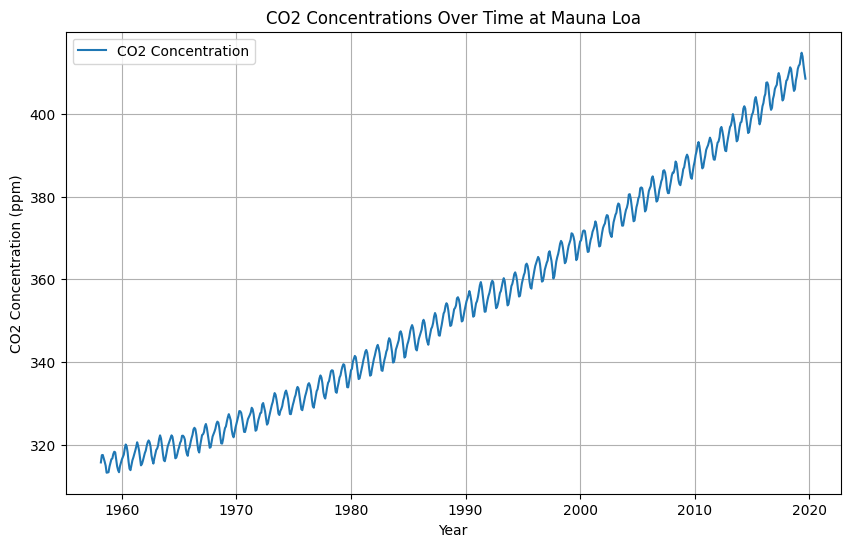

In [ ]:
import matplotlib.pyplot as plt

# Assuming `co2` is your DataFrame with 'Year', 'Month', and 'CO2' columns
plt.figure(figsize=(10, 6))
plt.plot(co2['Year'] + (co2['Month'] - 1) / 12, co2['CO2'], label='CO2 Concentration')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Concentrations Over Time at Mauna Loa')
plt.legend()
plt.grid(True)
plt.savefig('co2_concentrations.png')
plt.show()
